Simple Neural Network (Core)

In this assignment you will create a simple network	using dense layers.  You will also create 2 more versions of it where you adjust the number of layers and neurons per layer to see if you can achieve better performance.

Task: Create a deep learning model to predict heart disease in populations at risk.  
Data Source: Kaggle Heart Disease Dataset
Direct link to data: heart.csv

TASK: Use a neural network to predict heart disease using the given data.

**Make sure you:**

1. Explore and clean the data if needed.
2. Perform a train-test split on your data.
3. Use a column transformer to scale the numeric features and one-hot encode the categorical features.
4. Define your base sequential model.
5. Include the number of features of each sample in your input layer.
6. Use the correct activation function and the correct number of neurons for your output layer.
7. ompile your model with the correct loss function and an optimizer (‘adam’ is a fine choice)
8. Include a validation split when fitting the model.
9. Plot your model’s training history.
10. Evaluate your models with appropriate metrics.

After you’ve created, fit, and evaluated your first model, try 2 more versions of it with different numbers of layers and neurons to see if you can create a model that scores better on the testing data.

| Data Dictionary: | |
|---|---|
| Age: | age of the patient [years] |
| Sex: | sex of the patient [M: Male, F: Female] |
| ChestPainType: | chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] |
| RestingBP: | resting blood pressure [mm Hg] |
| Cholesterol: | serum cholesterol [mm/dl] |
| FastingBS: | fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] |
| RestingECG: | resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] |
| MaxHR: | maximum heart rate achieved [Numeric value between 60 and 202] |
| ExerciseAngina: | exercise-induced angina [Y: Yes, N: No] |
| Oldpeak: | oldpeak = ST [Numeric value measured in depression] |
| ST_Slope: | the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] |
| HeartDisease: | output class [1: heart disease, 0: Normal] |




In [ ]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [ ]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# check for missing data
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# check for duplicates
df.duplicated().sum()

0

In [ ]:
# Train Test split
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Check class balance
y_train.value_counts(normalize=True)

1    0.546512
0    0.453488
Name: HeartDisease, dtype: float64

In [ ]:
# create preprocessor
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

num_tuple = ('num', scaler, num_select)
cat_tuple = ('cat', ohe, cat_select)

processor = ColumnTransformer([num_tuple, cat_tuple], remainder='passthrough')

In [ ]:
# process the data
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

# Model 1

In [ ]:
# create and compile the model
model = keras.Sequential()
model.add(Dense(10, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [ ]:
# train the model and save the history
history = model.fit(X_train_processed, y_train,
          validation_split=.2,
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 4s 16ms/step - loss: 0.6798 - accuracy: 0.5800 - val_loss: 0.6609 - val_accuracy: 0.5797
Epoch 2/10
18/18 [==============================] - 0s 5ms/step - loss: 0.6570 - accuracy: 0.6582 - val_loss: 0.6420 - val_accuracy: 0.6014
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.7236 - val_loss: 0.6155 - val_accuracy: 0.7029
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6016 - accuracy: 0.7600 - val_loss: 0.5786 - val_accuracy: 0.7609
Epoch 5/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5649 - accuracy: 0.7891 - val_loss: 0.5403 - val_accuracy: 0.7826
Epoch 6/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5251 - accuracy: 0.8182 - val_loss: 0.5054 - val_accuracy: 0.7971
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.4873 - accuracy: 0.8255 - val_loss: 0.4734 - val_accuracy: 0.8043
Epoch 8/10
18/18 [=

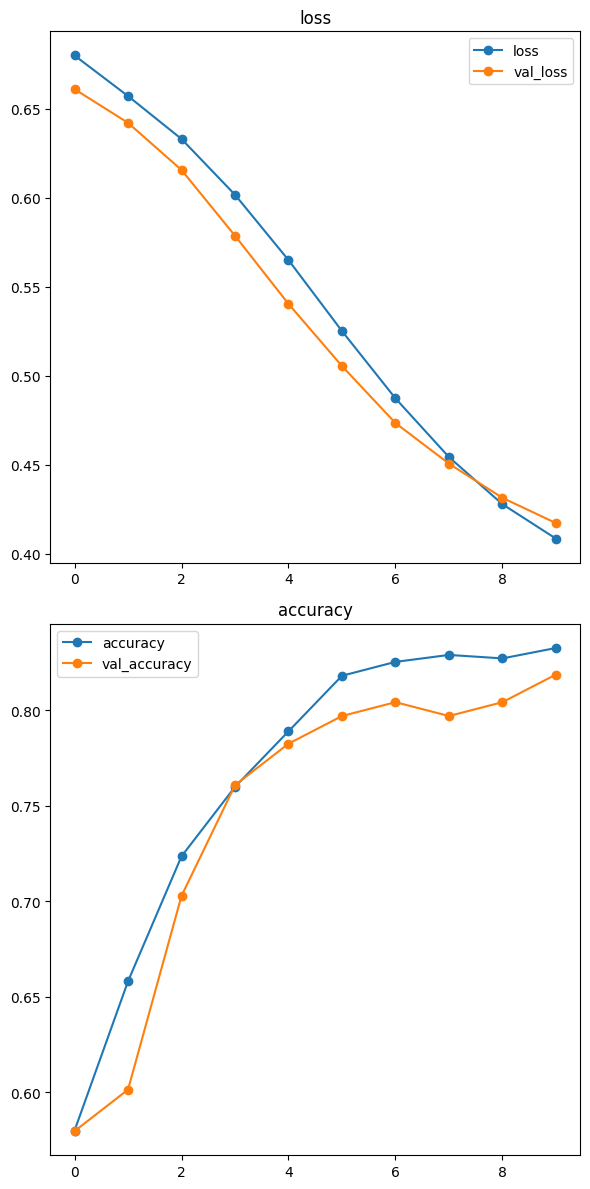

In [ ]:
# Call the custom function
plot_history(history);

In [ ]:
# Evaluate neural network with builtin evaluation
result = model.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 3ms/step - loss: 0.4322 - accuracy: 0.8261


{'loss': 0.432188481092453, 'accuracy': 0.8260869383811951}

8/8 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        98
           1       0.88      0.81      0.84       132

    accuracy                           0.83       230
   macro avg       0.82      0.83      0.82       230
weighted avg       0.83      0.83      0.83       230



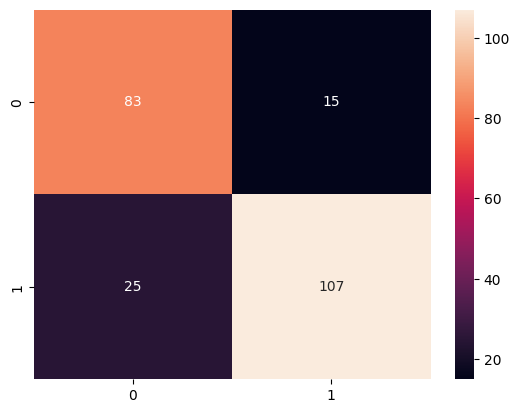

In [ ]:
# evaluate the model with sklearn metrics
test_preds = model.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

# Model 2: More Neurons

In [ ]:
# create model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [ ]:
# train the model and save the history
history = model2.fit(X_train_processed, y_train,
          validation_split=(.2),
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 1s 15ms/step - loss: 0.7779 - accuracy: 0.5600 - val_loss: 0.7431 - val_accuracy: 0.4855
Epoch 2/10
18/18 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.5545 - val_loss: 0.6747 - val_accuracy: 0.4855
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.5655 - val_loss: 0.6349 - val_accuracy: 0.5072
Epoch 4/10
18/18 [==============================] - 0s 5ms/step - loss: 0.6050 - accuracy: 0.5945 - val_loss: 0.6078 - val_accuracy: 0.5217
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5725 - accuracy: 0.6382 - val_loss: 0.5892 - val_accuracy: 0.5870
Epoch 6/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5445 - accuracy: 0.6927 - val_loss: 0.5739 - val_accuracy: 0.6377
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.7236 - val_loss: 0.5643 - val_accuracy: 0.6812
Epoch 8/10
18/18 [=

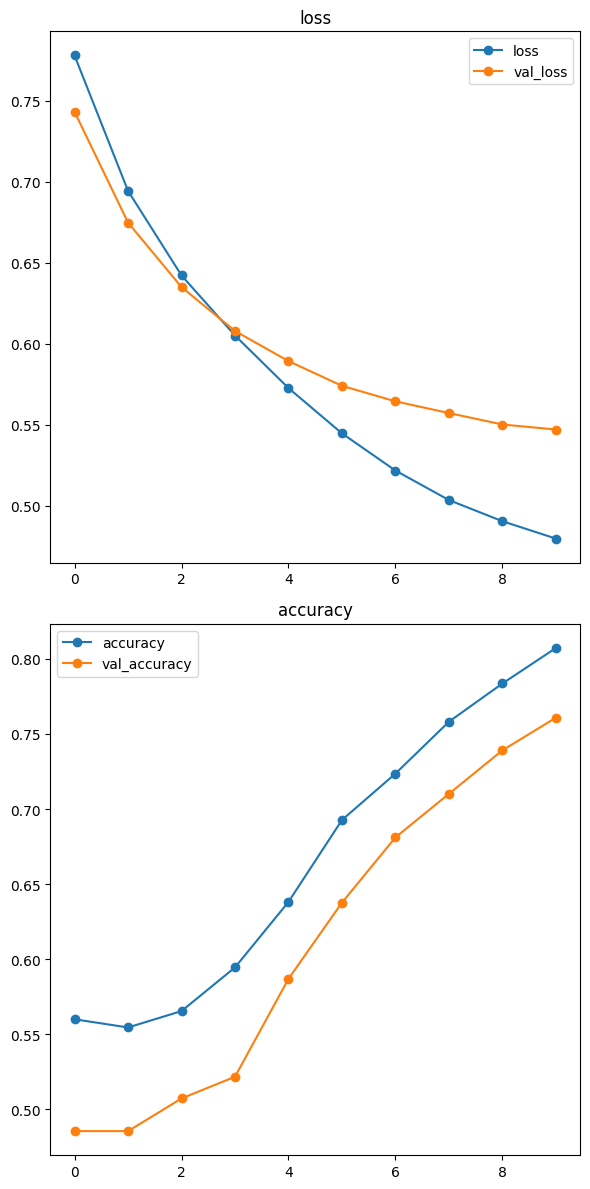

In [ ]:
plot_history(history);

In [ ]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 3ms/step - loss: 0.4675 - accuracy: 0.7870


{'loss': 0.46752193570137024, 'accuracy': 0.7869565486907959}

8/8 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        98
           1       0.75      0.95      0.84       132

    accuracy                           0.79       230
   macro avg       0.82      0.76      0.76       230
weighted avg       0.81      0.79      0.78       230



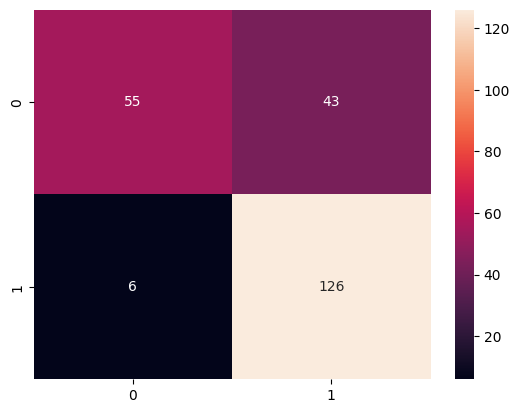

In [ ]:
# evaluate the model with sklearn metrics
test_preds = model2.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt = 'g');

# Model 3: More layers

In [ ]:
# create model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_processed.shape[1],
        activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [ ]:
# train the model and save the history
history = model3.fit(X_train_processed, y_train,
          validation_split = .2,
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 1s 15ms/step - loss: 0.6469 - accuracy: 0.5891 - val_loss: 0.7127 - val_accuracy: 0.5580
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6709 - val_loss: 0.6725 - val_accuracy: 0.5942
Epoch 3/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5635 - accuracy: 0.7273 - val_loss: 0.6524 - val_accuracy: 0.6377
Epoch 4/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5372 - accuracy: 0.7509 - val_loss: 0.6376 - val_accuracy: 0.7029
Epoch 5/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5150 - accuracy: 0.7727 - val_loss: 0.6142 - val_accuracy: 0.7174
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 0.4949 - accuracy: 0.7964 - val_loss: 0.5842 - val_accuracy: 0.7609
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.4752 - accuracy: 0.8127 - val_loss: 0.5721 - val_accuracy: 0.7826
Epoch 8/10
18/18 [=

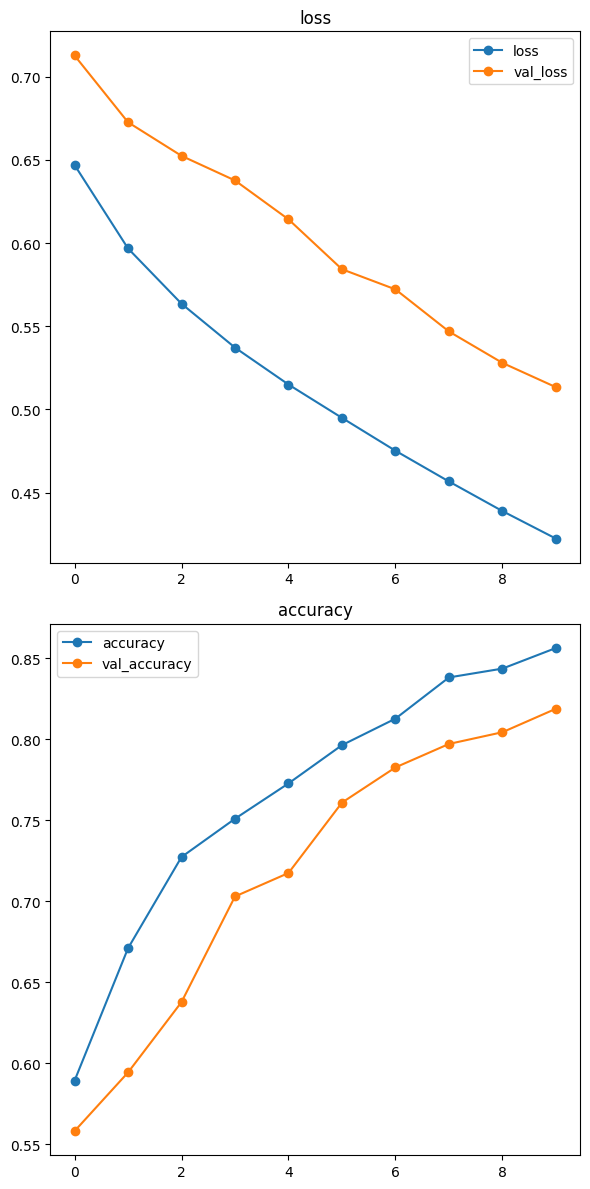

In [ ]:
# Obtain history
plot_history(history);


In [ ]:
# Evaluate neural network with builtin evaluation
result = model3.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8739


{'loss': 0.39801591634750366, 'accuracy': 0.873913049697876}

8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        98
           1       0.91      0.87      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.88      0.87      0.87       230



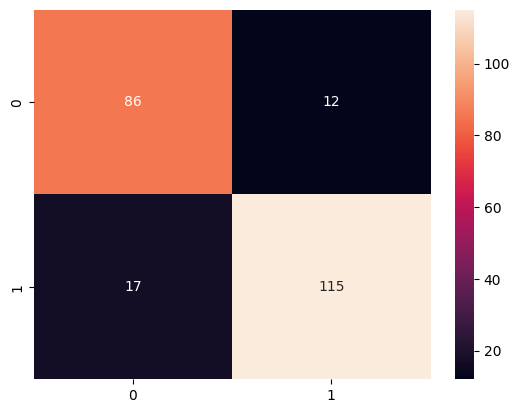

In [ ]:
# evaluate the model
test_preds = model3.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');